## Deep CNN for Fashion MNIST : PyTorch

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import random
import numpy as np
import matplotlib.pyplot as plt

## Step 0. Device Stepup

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print("Device : ", device)

Device :  cuda


Hyperparameters

In [15]:
learning_rate = 1e-3
batch_size = 100
epochs = 15

### Step 1. Data -  target class : 10

In [16]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [17]:
print('train_data :', train_data)
print('test_data :', test_data)

train_data : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data : Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Step 2. Deep CNN Model

In [18]:
# CNN Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = nn.Linear(4 * 4 * 128, 625, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            nn.Dropout(p=1 - self.keep_prob))
        
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = nn.Linear(625, 10, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out


model = CNN().to(device)

### Step 3. Loss and Optimizer

In [19]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 4. & 5. Train/Test the model

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    correct /= size
    print(f"Train - Avg loss: {train_loss:>8f},  Accuracy: {(100*correct):>0.1f}%", end = "  ")

    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test - Avg loss: {test_loss:>8f}  Accuracy: {(100*correct):>0.1f}%")

    return test_loss, correct

In [21]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for t in range(epochs):
    print(f"Epoch {t+1} :", end= "  ")
    loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)

    loss_t, acc_t = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(loss_t)
    test_acc.append(acc_t)

print("Done!")

Epoch 1 :  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train - Avg loss: 0.500449,  Accuracy: 81.8%  Test - Avg loss: 0.377592  Accuracy: 86.4%
Epoch 2 :  Train - Avg loss: 0.305578,  Accuracy: 88.9%  Test - Avg loss: 0.301874  Accuracy: 89.0%
Epoch 3 :  Train - Avg loss: 0.257501,  Accuracy: 90.5%  Test - Avg loss: 0.283906  Accuracy: 89.8%
Epoch 4 :  Train - Avg loss: 0.226212,  Accuracy: 91.7%  Test - Avg loss: 0.278738  Accuracy: 90.1%
Epoch 5 :  Train - Avg loss: 0.199807,  Accuracy: 92.4%  Test - Avg loss: 0.269416  Accuracy: 90.4%
Epoch 6 :  Train - Avg loss: 0.181175,  Accuracy: 93.2%  Test - Avg loss: 0.279186  Accuracy: 90.3%
Epoch 7 :  Train - Avg loss: 0.160006,  Accuracy: 94.0%  Test - Avg loss: 0.264398  Accuracy: 90.9%
Epoch 8 :  Train - Avg loss: 0.143786,  Accuracy: 94.6%  Test - Avg loss: 0.272926  Accuracy: 90.8%
Epoch 9 :  Train - Avg loss: 0.128559,  Accuracy: 95.1%  Test - Avg loss: 0.305446  Accuracy: 90.6%
Epoch 10 :  Train - Avg loss: 0.114775,  Accuracy: 95.6%  Test - Avg loss: 0.325156  Accuracy: 90.2%
Epoch 11 :

### Plot the Training/Test Loss

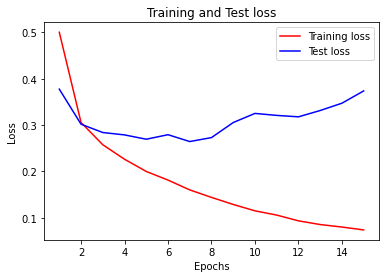

In [22]:
epochs = np.arange(1, epochs+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot the Training/Test Accuracy

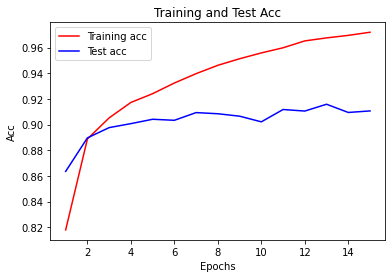

In [23]:
plt.clf()   # 그래프를 초기화합니다
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()